# Library loading

In [1]:
import scanpy as sc, anndata as ad, numpy as np, pandas as pd
from scipy import sparse
from anndata import AnnData
import warnings
import socket
import holoviews as hv
import plotly.express as px
import seaborn as sns


from matplotlib import pylab
import sys
import yaml
import os
from pandas.api.types import CategoricalDtype
import plotly
import random


import matplotlib.pyplot as plt

warnings.filterwarnings('ignore')

In [2]:
plotly.offline.init_notebook_mode()

In [3]:
%matplotlib inline

In [4]:
sc.settings.verbosity = 3         # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=50, facecolor='white')
pylab.rcParams['figure.figsize'] = (9, 9)


scanpy==1.8.1 anndata==0.7.6 umap==0.4.6 numpy==1.20.2 scipy==1.6.3 pandas==1.2.4 scikit-learn==0.24.2 statsmodels==0.13.1 python-igraph==0.9.8 louvain==0.7.1 pynndescent==0.5.5


### Configure paths

In [5]:
hostRoot = "-".join(socket.gethostname().split('-')[0:2])

with open(os.path.expanduser('~')+"/paths_config.yaml", 'r') as f:
    paths = yaml.load(f, Loader=yaml.FullLoader)

#indir=paths["paths"]["indir"][hostRoot]
FinaLeaf="/Neurons"
outdir="./outdir/"
#projectBaseDir=paths["paths"]["projectBaseDir"][hostRoot]
adataPath = outdir+FinaLeaf+"/4A_Neurons_DA.h5ad"
adataRawPath = outdir+"/3_polaroid_quickAnno.h5ad"

figDir = "./figures/"
outBaseName = "04.2A_Neurons_inDepthComposition"
badhuriMarkers = ["PAX6","DDIT3","NEUROG2","CNBP","HMGB2","ZNF707","CAMTA1","SUB1","THYN1","NEUROG1","HMGB3","NFIX","BCL11A","TCF4","NR2F1"]
RAmarkersPath = "./data/resources/RA_signalling.tsv"
RAmarkersDF = pd.read_csv(RAmarkersPath, sep="\t")
with open("./colorMap.yaml", 'r') as f:
    colorMap = yaml.load(f, Loader=yaml.FullLoader)["uns_colors"]

# Load adata

In [6]:
adata = sc.read_h5ad(adataPath)


In [7]:
adata

AnnData object with n_obs × n_vars = 3650 × 28371
    obs: 'dataset', 'organoid', 'region', 'type', 'type_region', 'regionContrast', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'n_genes', 'is.Stressed', 'leiden0.3', 'S_score', 'G2M_score', 'phase', 'subLeiden', 'umap_density_type', 'umap_density_region', 'umap_density_organoid'
    var: 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable'
    uns: 'dataset_colors', 'diffmap_evals', 'draw_graph', 'leiden', 'neighbors', 'organoid_colors', 'pca', 'regionContrast_colors', 'region_colors', 'subLeiden_colors', 'type_colors', 'umap', 'umap_density_organoid_params', 'umap_density_region_params', 'umap_density_type_params'
    obsm: 'X_diffmap', 'X_draw_graph_fa', 'X_pc

# UMAP

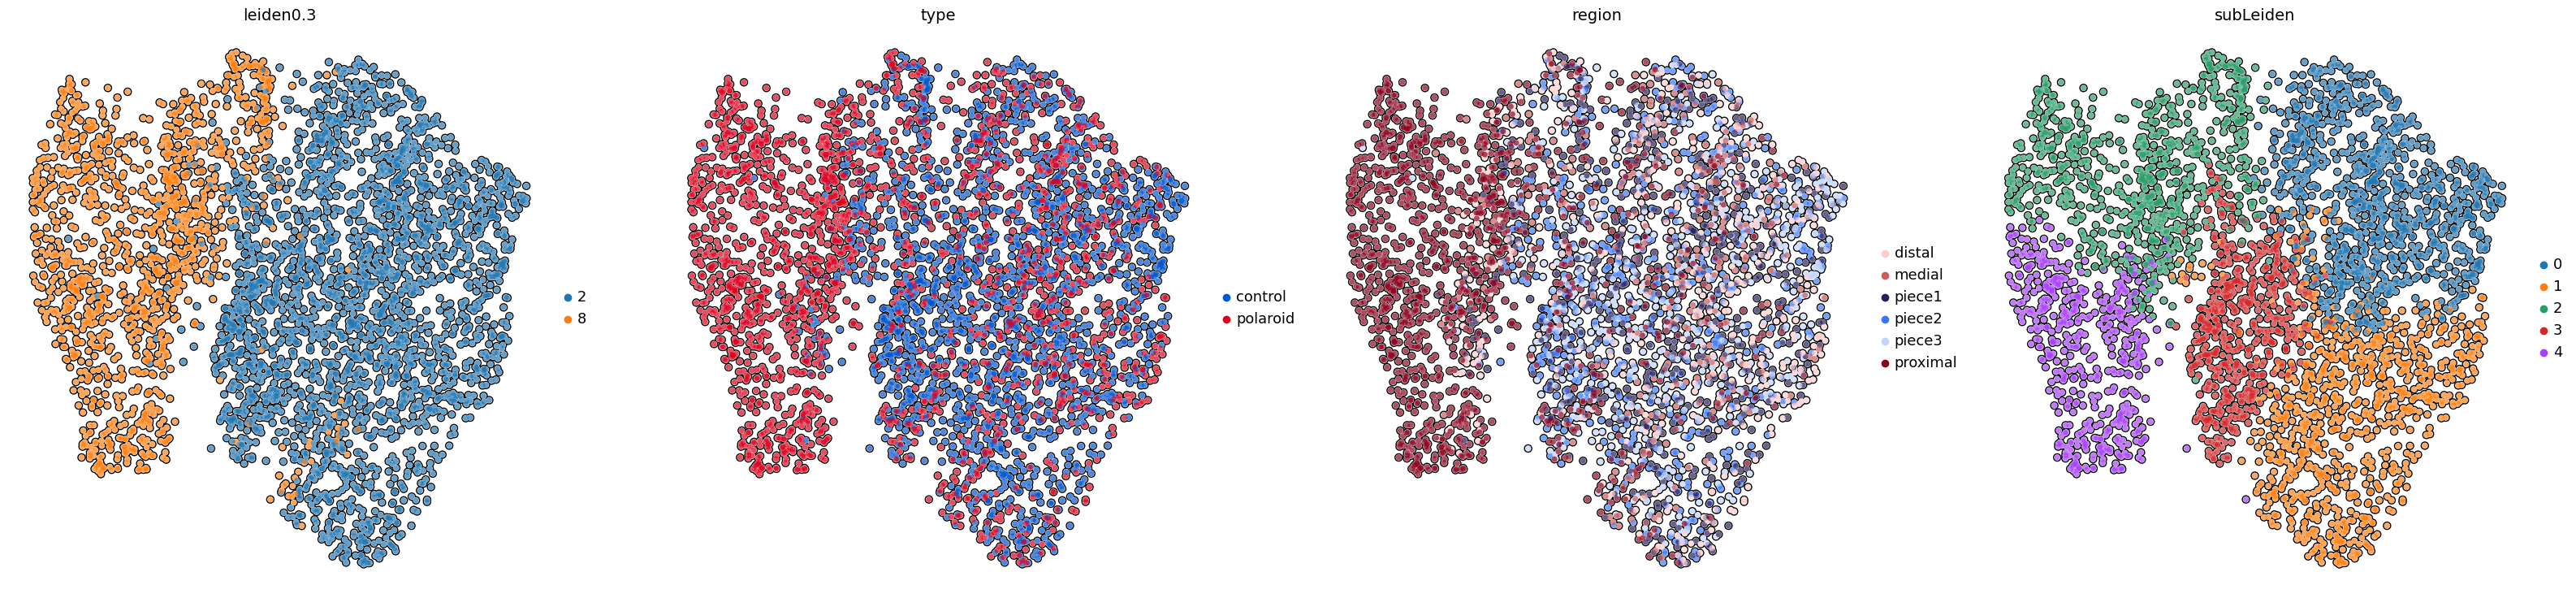

In [8]:
sc.pl.umap(adata, color=["leiden0.3","type","region","subLeiden"] ,size = 100, add_outline = True,outline_width=(0.2, 0.05), frameon=False)

## Boxplot of hexogenes

In [9]:
hexogenes = ["FGF8b.WPRE.SV40" ,  "SA.p2a.PURO.BGH", "p2a.dTom.rbGlob" ]

## By segment

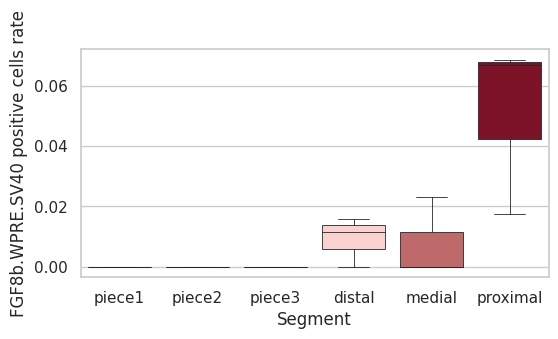

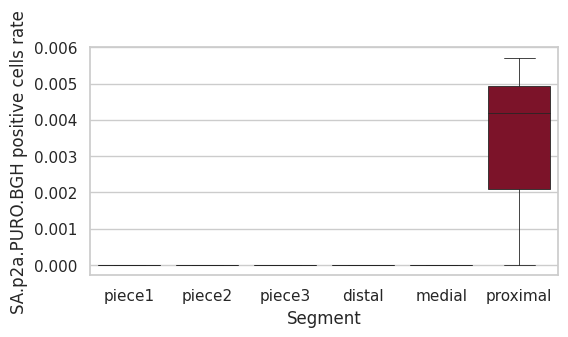

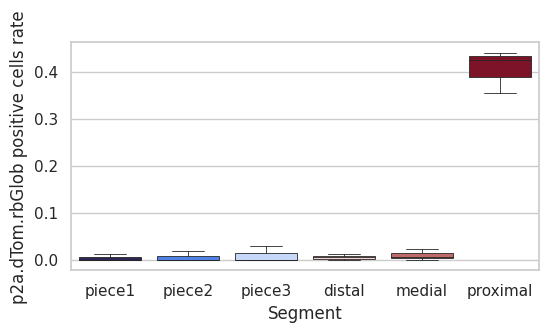

In [10]:
sns.set(rc={'figure.figsize':(6,3)})

sns.set_style("whitegrid")


for gene in  [m for m in hexogenes if m in adata.var_names]:
    adataGene = sc.read_h5ad(adataRawPath).raw.to_adata()[adata.obs_names,gene]
    adataGene.obs = adata.obs.copy()
    dummies = pd.get_dummies(adataGene.obs["dataset"])
    
    countsAbove0 = (adataGene.X.todense().A1 > 0).astype(int)
    
    
    SegmentCounts = pd.DataFrame(np.dot(countsAbove0, dummies),columns=[gene+"_positive"])
    SegmentCounts["dataset"] = dummies.columns.tolist()
    SegmentCounts["organoid"] = SegmentCounts["dataset"].str.split("_", expand=True)[0]
    SegmentCounts["Segment"] = SegmentCounts["dataset"].str.split("_", expand=True)[1]

    SegmentCounts["Total_perOrganoid"] = adataGene.obs.groupby(["organoid"]).size().loc[SegmentCounts.organoid].tolist()
    SegmentCounts["Total_perSegment_perOrganoid"] = adataGene.obs.groupby(["dataset"]).size().loc[SegmentCounts.dataset].tolist()
    SegmentCounts[gene+"_positive.NormalizedByOrganoid"] = SegmentCounts[gene+"_positive"] / SegmentCounts["Total_perOrganoid"]
    SegmentCounts[gene+" positive cells rate"] = SegmentCounts[gene+"_positive"] / SegmentCounts["Total_perSegment_perOrganoid"]



    sns.boxplot(data=SegmentCounts, x="Segment", y=gene+" positive cells rate", 
                linewidth=.6,
                palette=dict(zip(SegmentCounts.Segment.unique().tolist(),[colorMap[k]["color"] for k in SegmentCounts.Segment.unique().tolist()])))
    plt.show()



## By subleiden

In [11]:
sns.set(rc={'figure.figsize':(6,3)})

sns.set_style("whitegrid")

adatalocal = sc.read_h5ad(adataRawPath).raw.to_adata()[adata.obs_names]
for gene in  [m for m in hexogenes if m in adata.var_names]:
    adataGene = adatalocal[:,gene]

    adataGene.obs = adata.obs.copy()
    dummies = pd.get_dummies(adataGene.obs["subLeiden"])
    
    countsAbove0 = (adataGene.X.todense().A1 > 0).astype(int)
    
    
    print(adataGene.X.sum())
    
    
    SegmentCounts = pd.DataFrame(np.dot(countsAbove0, dummies),columns=[gene+"_positive"])
    SegmentCounts["subLeiden"] = dummies.columns.tolist()
    SegmentCounts["Total_subLeiden"] = adataGene.obs.groupby(["subLeiden"]).size().loc[SegmentCounts.subLeiden].tolist()
    #SegmentCounts["Total_perSegment_perOrganoid"] = adataGene.obs.groupby(["dataset"]).size().loc[SegmentCounts.dataset].tolist()
    #SegmentCounts[gene+"_positive.NormalizedByOrganoid"] = SegmentCounts[gene+"_positive"] / SegmentCounts["Total_perOrganoid"]
    SegmentCounts[gene+" positive cells rate"] = SegmentCounts[gene+"_positive"] / SegmentCounts["Total_subLeiden"]



    fig = px.bar(SegmentCounts, x="subLeiden", y=gene+" positive cells rate", color="subLeiden", 
                  height=800,width=1000, template="plotly_white",

                 color_discrete_map = dict(zip(adata.obs["subLeiden"].cat.categories,adata.uns["subLeiden_colors"])),title="## Normalized by region and subleiden",
    )
    
    fig.update_traces(marker_line_color='black',
                  marker_line_width=1, opacity=1)
    fig.update_layout( yaxis = dict( tickfont = dict(size=30), title_font=dict(size=30)),legend = dict(font = dict(size = 30)), 
                  xaxis = dict( tickfont = dict(size=30), title_font=dict(size=30)))
    
    fig.show()

108.708664


3.1453545


514.9531
